# Notebook de prédiction
## Importation des librairies Python

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
from scipy.stats import pearsonr
from sklearn import decomposition
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, KFold, ShuffleSplit
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,fbeta_score, make_scorer

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

sns.set(color_codes=True)

## Définition de notre target et des fonctions utilisées

In [2]:
target = 'SiteEnergyUse(kBtu)'

## Importation du DataFrame 

In [3]:
seattle_pred = pd.read_csv('seattle_data_clean.csv')
seattle_pred = seattle_pred.drop(seattle_pred.columns[0], axis = 1)

In [4]:
seattle_pred.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,...,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,ComplianceStatus,ZipCode,Latitude,Longitude
0,1,2016,NonResidential,Hotel,0659000030,7,DOWNTOWN,1927,1.0,12.0,...,7226362.5,2003882.00,3946027.0,1276453.0,249.98,2.83,Compliant,98101.0,47.61220,-122.33799
1,2,2016,NonResidential,Hotel,0659000220,7,DOWNTOWN,1996,1.0,11.0,...,8387933.0,0.00,3242851.0,5145082.0,295.86,2.86,Compliant,98101.0,47.61317,-122.33393
2,3,2016,NonResidential,Hotel,0659000475,7,DOWNTOWN,1969,1.0,41.0,...,72587024.0,21566554.00,49526664.0,1493800.0,2089.28,2.19,Compliant,98101.0,47.61393,-122.33810
3,5,2016,NonResidential,Hotel,0659000640,7,DOWNTOWN,1926,1.0,10.0,...,6794584.0,2214446.25,2768924.0,1811213.0,286.43,4.67,Compliant,98101.0,47.61412,-122.33664
4,8,2016,NonResidential,Hotel,0659000970,7,DOWNTOWN,1980,1.0,18.0,...,14172606.0,0.00,5368607.0,8803998.0,505.01,2.88,Compliant,98121.0,47.61375,-122.34047


In [5]:
seattle_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3382 entries, 0 to 3381
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OSEBuildingID                  3382 non-null   int64  
 1   DataYear                       3382 non-null   int64  
 2   BuildingType                   3382 non-null   object 
 3   PrimaryPropertyType            3382 non-null   object 
 4   TaxParcelIdentificationNumber  3381 non-null   object 
 5   CouncilDistrictCode            3382 non-null   int64  
 6   Neighborhood                   3382 non-null   object 
 7   YearBuilt                      3382 non-null   int64  
 8   NumberofBuildings              3374 non-null   float64
 9   NumberofFloors                 3382 non-null   float64
 10  PropertyGFATotal               3382 non-null   int64  
 11  PropertyGFAParking             3382 non-null   int64  
 12  PropertyGFABuilding(s)         3382 non-null   i

## Choix des variables et transformations

Afin d'éviter de possibles fuites de données et d'avoir un algorithme pertinent, il est important de regarder les variables que nous allons intégrer. 

Notre Target ici est **SiteEnergyUse(kBtu)**. Elle représente donc l'énergie utilisée par chacun des sites que nous avons en base. 

Regardons les variables reliées aux énergies pour voir si elles sont pertinentes :

- **ENERGYSTARScore** : Cette variables est déjà une prédiction réalisée avec les autres données dont nous disposons, nous allons donc la mettre de côté pour le moment. 

- **SiteEUI(kBtu/sf)** & **SourceEUI(kBtu/sf)** : EUI pour Energy Use Intensity. Ces variables sont en fait la SiteEnergyUse par année divisée par la surface totale du bâtiment. Trop similaire à notre target, nous allons les retirer.

- **Electricity**, **NaturalGas** & **SteamUse(kBtu)** : Leur somme donne SiteEnergyUse(kBtu), notre cible, nous allons donc les retirer de notre modèle.

- **GHGEmissionsIntensity** & **TotalGHGEmissions**: Nous allons retirer les deux variables de peur de fausser nos performances*.

In [6]:
seattle_pred['PropertyGFAParking(%)'] = seattle_pred['PropertyGFAParking'] * 100 / seattle_pred['PropertyGFATotal']
seattle_pred['PropertyGFABuilding(s)(%)'] = seattle_pred['PropertyGFABuilding(s)'] * 100 / seattle_pred['PropertyGFATotal']

In [7]:
seattle_pred.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,...,Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,ComplianceStatus,ZipCode,Latitude,Longitude,PropertyGFAParking(%),PropertyGFABuilding(s)(%)
0,1,2016,NonResidential,Hotel,0659000030,7,DOWNTOWN,1927,1.0,12.0,...,3946027.0,1276453.0,249.98,2.83,Compliant,98101.0,47.61220,-122.33799,0.000000,100.000000
1,2,2016,NonResidential,Hotel,0659000220,7,DOWNTOWN,1996,1.0,11.0,...,3242851.0,5145082.0,295.86,2.86,Compliant,98101.0,47.61317,-122.33393,14.545314,85.454686
2,3,2016,NonResidential,Hotel,0659000475,7,DOWNTOWN,1969,1.0,41.0,...,49526664.0,1493800.0,2089.28,2.19,Compliant,98101.0,47.61393,-122.33810,20.574829,79.425171
3,5,2016,NonResidential,Hotel,0659000640,7,DOWNTOWN,1926,1.0,10.0,...,2768924.0,1811213.0,286.43,4.67,Compliant,98101.0,47.61412,-122.33664,0.000000,100.000000
4,8,2016,NonResidential,Hotel,0659000970,7,DOWNTOWN,1980,1.0,18.0,...,5368607.0,8803998.0,505.01,2.88,Compliant,98121.0,47.61375,-122.34047,35.311539,64.688461


In [8]:
seattle_pred.Neighborhood.unique()

array(['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST', 'CENTRAL', 'NORTH',
       'MAGNOLIA / QUEEN ANNE', 'LAKE UNION', 'GREATER DUWAMISH',
       'BALLARD', 'NORTHWEST', 'SOUTHWEST', 'DELRIDGE'], dtype=object)

In [9]:
seattle_pred.NeighborhoodNum = seattle_pred.Neighborhood.replace(seattle_pred.Neighborhood.unique(),[1,2,3,4,5,6,7,8,9,10,11,12,13])

<ipython-input-9-2071ca14cf7a>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  seattle_pred.NeighborhoodNum = seattle_pred.Neighborhood.replace(seattle_pred.Neighborhood.unique(),[1,2,3,4,5,6,7,8,9,10,11,12,13])


In [10]:
drop_columns = ['OSEBuildingID','TaxParcelIdentificationNumber','ComplianceStatus','PropertyGFAParking','PropertyGFABuilding(s)','Neighborhood',
                'ListOfAllPropertyUseTypes', 'PrimaryPropertyType', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)','SourceEUI(kBtu/sf)', 'ZipCode',
               'Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)', 'Latitude', 'Longitude', 'GHGEmissionsIntensity','TotalGHGEmissions','DataYear']

In [11]:
data_pred = seattle_pred.drop(drop_columns, axis=1).dropna()

In [12]:
data_pred.shape

(3345, 11)

In [13]:
data_pred.columns

Index(['BuildingType', 'CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SiteEnergyUse(kBtu)',
       'PropertyGFAParking(%)', 'PropertyGFABuilding(s)(%)'],
      dtype='object')

## Préparation des données
Nous allons numériser les variables catégorielles afin de pouvoir les incorporer dans un modèle.

In [14]:
df_numeric = pd.get_dummies(data_pred)
df_ml = df_numeric.loc[(df_numeric[target] != 0)]

feature_names = df_ml.drop(target,axis=1).columns

In [15]:
x = df_ml.drop(target,axis=1).values
y = df_ml[target].values

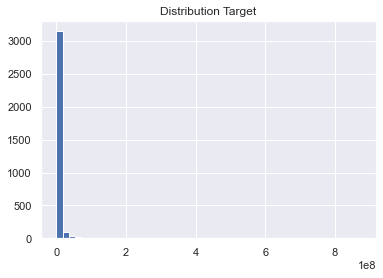

In [16]:
plt.figure()
plt.title('Distribution Target')
plt.hist(y, bins=50)
plt.show()

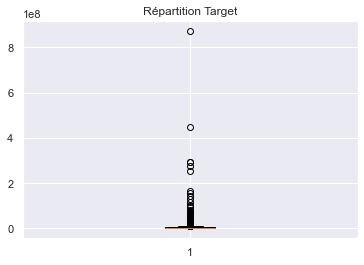

In [17]:
plt.figure()
plt.title('Répartition Target')
plt.boxplot(y)
plt.show()

Nous allons passer au log notre target y afin de réduire l'espace des valeurs. Nous profitons pour Scaler en même temps notre entrée **x**.

In [18]:
Y = np.log(y)

In [19]:
std = StandardScaler()
X = std.fit_transform(x)

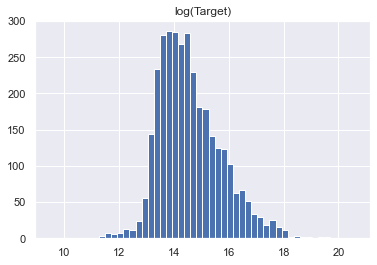

In [20]:
plt.figure()
plt.title('log(Target)')
plt.hist(Y, bins=50)
plt.show()

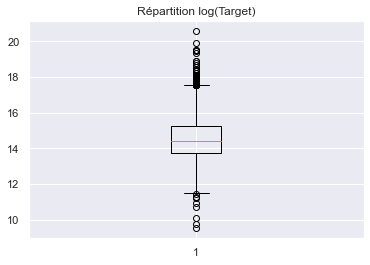

In [21]:
plt.figure()
plt.title('Répartition log(Target)')
plt.boxplot(Y)
plt.show()

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)

In [23]:
evaluation = pd.DataFrame(columns=['Modele','R2_Initial','RMSE_Initial','R2_Final',
                                   'RMSE_Final','alpha', 'max_depth', 'n_estimators'])
evaluation.Modele = ['Regression Ridge', 'Random Forest Regressor', 'XGBoost Regressor']

In [24]:
evaluation

,Modele,R2_Initial,RMSE_Initial,R2_Final,RMSE_Final,alpha,max_depth,n_estimators
0,Regression Ridge,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Random Forest Regressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,XGBoost Regressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Regression Ridge

In [25]:
rdg = Ridge()
rdg.fit(X_train, y_train)

Ridge()

In [26]:
y_pred = rdg.predict(X_test)

In [27]:
print('RMSE: %.3f'
      % np.sqrt(mean_squared_error(y_test, y_pred)))

print('R2: %.3f'
      % rdg.score(X_test, y_test))

RMSE: 0.752
R2: 0.553


In [28]:
rdg.get_params(deep=True)

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

Nous ajoutons ces valeurs dans notre df de suivi :

In [29]:
evaluation.iloc[0][1]=r2_score(y_test, y_pred).round(3)
evaluation.iloc[0][2]=np.sqrt(mean_squared_error(y_test, y_pred)).round(3)
evaluation

,Modele,R2_Initial,RMSE_Initial,R2_Final,RMSE_Final,alpha,max_depth,n_estimators
0,Regression Ridge,0.553,0.752,NaN,NaN,NaN,NaN,NaN
1,Random Forest Regressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,XGBoost Regressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Feature importances

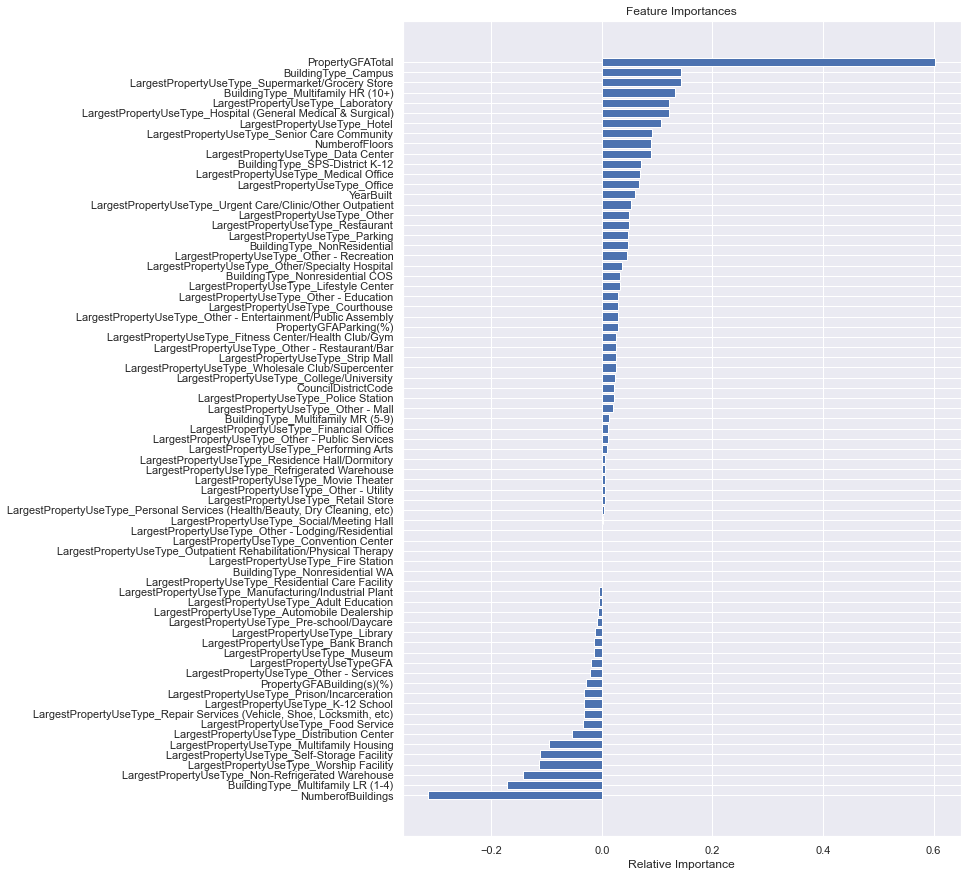

In [30]:
importances = rdg.coef_
indices = np.argsort(importances)

plt.figure(figsize=(10, 15))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Recherche de alpha
#### GridSearchCV
Nous utilisons ici GridSearchCV afin d'optimiser notre valeur d'**alpha** afin d'avoir de meilleures performances.

In [31]:
#params = {'alpha':np.arange(1,1000,1)}
params = {'alpha':[1,10,100,500,1000,5000]}

score_function= make_scorer(mean_squared_error)

grid = GridSearchCV(Ridge(), param_grid=params, cv=5, scoring="neg_mean_squared_error", refit = True, n_jobs=-1, verbose = 5)#"neg_mean_squared_error",
grid.fit(X_train, y_train)

grid_res = pd.DataFrame(grid.cv_results_)
#print("Meilleurs Estimator: %s" % grid.best_estimator_)
#print("Meilleurs paramètres: %s" % grid.best_params_)
#print("Meilleur Score: %.3f" % grid.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  30 | elapsed:    2.0s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  21 out of  30 | elapsed:    2.0s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  28 out of  30 | elapsed:    2.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.1s finished


In [32]:
grid_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.015625,0.000002,0.0,0.0,1,{'alpha': 1},-3.407164,-0.664988,-0.675690,-0.540936,-0.732604,-1.204276,1.103218,6
1,0.015625,0.000002,0.0,0.0,10,{'alpha': 10},-3.320367,-0.661454,-0.674769,-0.539296,-0.732294,-1.185636,1.069215,5
2,0.009377,0.007656,0.0,0.0,100,{'alpha': 100},-2.763342,-0.639338,-0.682758,-0.541946,-0.731529,-1.071783,0.848083,4
3,0.003125,0.006249,0.0,0.0,500,{'alpha': 500},-1.742052,-0.624172,-0.710508,-0.586713,-0.739296,-0.880548,0.434309,3
4,0.012500,0.006250,0.0,0.0,1000,{'alpha': 1000},-1.288822,-0.638447,-0.735271,-0.633154,-0.757488,-0.810636,0.244260,1
5,0.003125,0.006250,0.0,0.0,5000,{'alpha': 5000},-0.821022,-0.789624,-0.885567,-0.843029,-0.915677,-0.850984,0.044961,2


In [33]:
best_ridge = Ridge(alpha=grid.best_params_['alpha'])
best_ridge.fit(X_train, y_train)
y_pred = best_ridge.predict(X_test)
print("Meilleur R²: %.5f" % best_ridge.score(X_test, y_test))

Meilleur R²: 0.50800


#### Visualisation

In [34]:
alpha = [1,10,100,500,1000,5000]

score = []
error = []

for i in alpha :
    ridge = Ridge()
    ridge.set_params(alpha=i)
    ridge.fit(X_train, y_train)
    score.append(ridge.score(X_test, y_test))
    error.append(np.mean((ridge.predict(X_test) - y_test) ** 2))

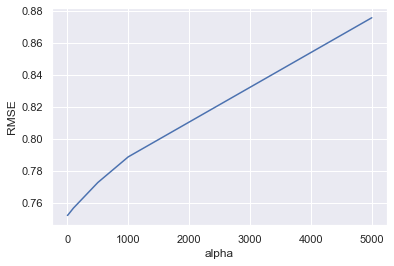

In [35]:
ax = plt.gca()
ax.plot(alpha, np.sqrt(error))
#ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.show()

In [36]:
ridge = Ridge(alpha=500)
ridge.fit(X_train, y_train)

Ridge(alpha=500)

In [37]:
y_pred = ridge.predict(X_test)

print('RMSE: %.3f'
      % np.sqrt(mean_squared_error(y_test, y_pred)))

print('R2: %.3f'
      % r2_score(y_test, y_pred))

RMSE: 0.773
R2: 0.528


In [38]:
evaluation.iloc[0][3]=r2_score(y_test, y_pred).round(3)
evaluation.iloc[0][4]=np.sqrt(mean_squared_error(y_test, y_pred)).round(3)
evaluation.iloc[0][5]=500
evaluation

,Modele,R2_Initial,RMSE_Initial,R2_Final,RMSE_Final,alpha,max_depth,n_estimators
0,Regression Ridge,0.553,0.752,0.528,0.773,500,NaN,NaN
1,Random Forest Regressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,XGBoost Regressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN


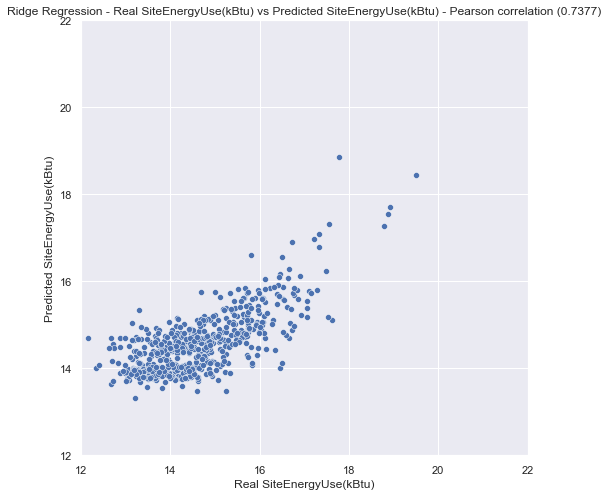

In [39]:
correlation = round(pearsonr(y_pred, y_test)[0], 5)
 
output_filename = "RidgeRegression.png"
title_name = "Ridge Regression - Real SiteEnergyUse(kBtu) vs Predicted SiteEnergyUse(kBtu) - Pearson correlation ({})".format(correlation)
x_axis_label = "Real SiteEnergyUse(kBtu)"
y_axis_label = "Predicted SiteEnergyUse(kBtu)"
 
plt.figure(figsize=(8, 8))
plt.title(title_name)

ax = sns.scatterplot(x=y_test, y=y_pred)

ax.set(xlabel=x_axis_label, ylabel=y_axis_label)
plt.xlim(12,22)
plt.ylim(12,22)
plt.savefig(output_filename, bbox_inches='tight', dpi=300)
plt.show()
plt.close()

## Random Forest Regressor 

In [40]:
regressor = RandomForestRegressor(max_depth = 5, n_estimators = 100)
regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=5)

In [41]:
y_pred = regressor.predict(X_test)

In [42]:
print('RMSE: %.3f'
      % np.sqrt(mean_squared_error(y_test, y_pred)))

print('R2: %.3f'
      % r2_score(y_test, y_pred))

RMSE: 0.602
R2: 0.714


In [43]:
evaluation.iloc[1][1]=r2_score(y_test, y_pred).round(3)
evaluation.iloc[1][2]=np.sqrt(mean_squared_error(y_test, y_pred)).round(3)
evaluation

,Modele,R2_Initial,RMSE_Initial,R2_Final,RMSE_Final,alpha,max_depth,n_estimators
0,Regression Ridge,0.553,0.752,0.528,0.773,500,NaN,NaN
1,Random Forest Regressor,0.714,0.602,NaN,NaN,NaN,NaN,NaN
2,XGBoost Regressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
regressor.get_params(deep=True)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Feature importances

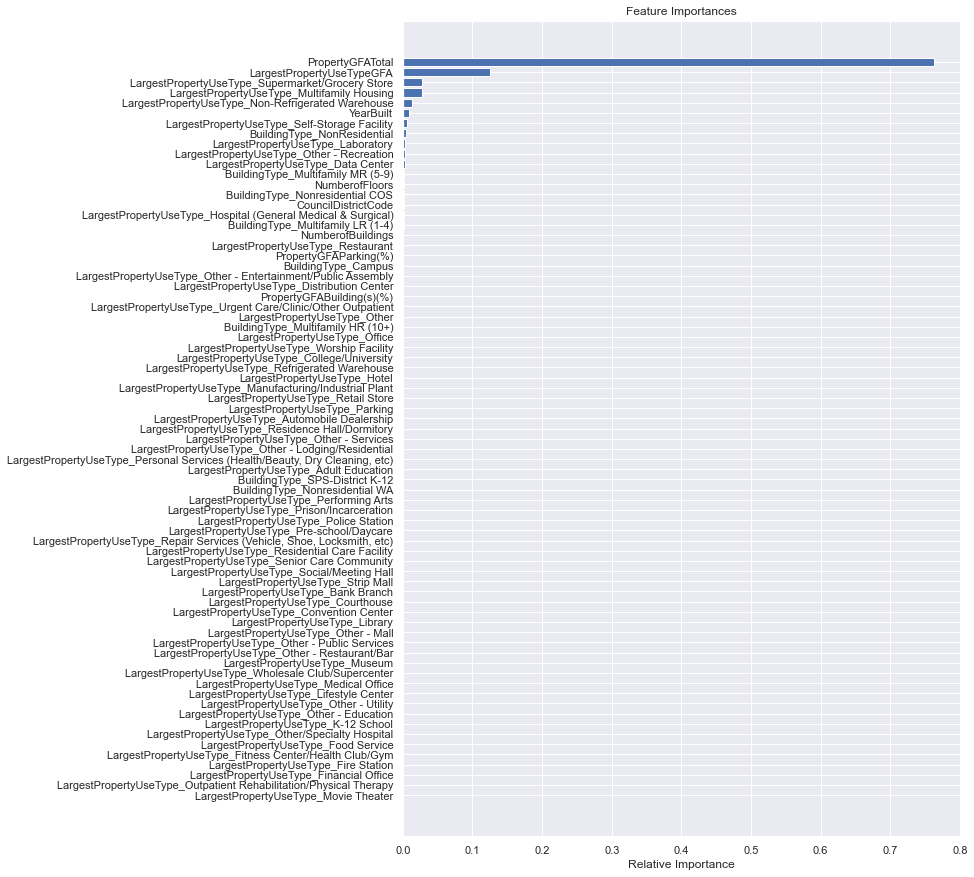

In [45]:
importances = regressor.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 15))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Recherche des hyperparamètres
#### GridSearchCV
Nous utilisons ici GridSearchCV afin d'optimiser notre valeur de **n_estimators & max_depth** afin d'avoir de meilleures performances.

In [46]:
regressor = RandomForestRegressor(random_state=0)

params = {'max_depth': [2, 5, 10, 20, 50], 
          'n_estimators' : [100, 500, 1000, 2000]}

grid1 = GridSearchCV(estimator=regressor, param_grid=params, refit = True, cv=5)
grid1.fit(X, Y)
grid1_res = pd.DataFrame(grid1.cv_results_)


#print("Meilleurs paramètres: %s" % grid1.best_params_)
#print("RMSE des meilleurs paramètres: %.3f" % np.sqrt(abs(grid1.best_score_)))

In [47]:
grid1_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.268484,0.017957,0.006250,0.007655,2,100,"{'max_depth': 2, 'n_estimators': 100}",0.336739,0.386197,0.498139,0.377566,0.550167,0.429762,0.080559,20
1,1.286046,0.082551,0.025002,0.007657,2,500,"{'max_depth': 2, 'n_estimators': 500}",0.335072,0.389214,0.497987,0.379091,0.550282,0.430329,0.080444,19
2,3.769965,0.326163,0.085874,0.017083,2,1000,"{'max_depth': 2, 'n_estimators': 1000}",0.337041,0.388436,0.498331,0.378901,0.550841,0.430710,0.080311,18
3,6.060075,0.892768,0.124754,0.013929,2,2000,"{'max_depth': 2, 'n_estimators': 2000}",0.338101,0.387313,0.498590,0.379923,0.551019,0.430989,0.080151,17
4,0.555578,0.098621,0.009375,0.007655,5,100,"{'max_depth': 5, 'n_estimators': 100}",0.553980,0.467006,0.625560,0.534908,0.683373,0.572966,0.074823,16
5,3.307058,0.679137,0.050138,0.012109,5,500,"{'max_depth': 5, 'n_estimators': 500}",0.558410,0.468556,0.624730,0.534126,0.682473,0.573659,0.073879,13
6,6.736422,0.674376,0.103975,0.041283,5,1000,"{'max_depth': 5, 'n_estimators': 1000}",0.558746,0.467097,0.624273,0.533603,0.681421,0.573028,0.073966,15
7,10.666514,0.986562,0.192453,0.055174,5,2000,"{'max_depth': 5, 'n_estimators': 2000}",0.559426,0.467479,0.624535,0.533350,0.681379,0.573234,0.073882,14
8,1.215129,0.213379,0.019457,0.008074,10,100,"{'max_depth': 10, 'n_estimators': 100}",0.571914,0.513742,0.657250,0.564975,0.707480,0.603072,0.069625,8
9,5.316771,1.365164,0.061360,0.014772,10,500,"{'max_depth': 10, 'n_estimators': 500}",0.573282,0.514562,0.657858,0.569912,0.710700,0.605263,0.069832,2


In [48]:
best_RFR = RandomForestRegressor(max_depth=grid1.best_params_['max_depth'])
best_RFR.fit(X_train, y_train)
y_pred = best_RFR.predict(X_test)
print("Meilleur R²: %.5f" % r2_score(y_test,y_pred))

Meilleur R²: 0.75001


#### Visualisation

Nous allons tester différentes valeurs pour les paramètres **max_depth** et **n_estimators** puis les visualiser graphiquement. Commençons par **max_depth**. 

In [49]:
max_depth = np.arange(1,56,5)
regressor = RandomForestRegressor(random_state=0)

score = []
error= []

for i in max_depth :
    regressor.set_params(max_depth=i)
    regressor.fit(X_train, y_train)
    score.append(regressor.score(X_test, y_test))
    error.append(np.mean((regressor.predict(X_test) - y_test) ** 2))

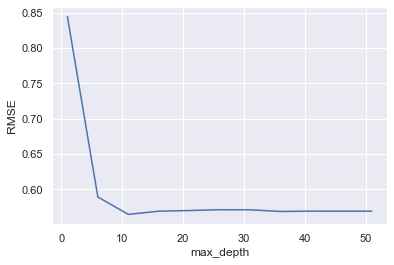

In [50]:
ax = plt.gca()
ax.plot(max_depth, np.sqrt(error))
#ax.set_xscale('log')
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.show()

Nous nous centrons plus précisément en 10 et 50 pour en apprendre d'avantage

In [51]:
max_depth = np.arange(10,50,2)
regressor = RandomForestRegressor(random_state=0)

score = []
error= []

for i in max_depth :
    regressor.set_params(max_depth=i)
    regressor.fit(X_train, y_train)
    score.append(regressor.score(X_test, y_test))
    error.append(np.mean((regressor.predict(X_test) - y_test) ** 2))

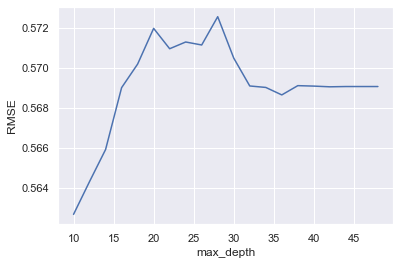

In [52]:
ax = plt.gca()
ax.plot(max_depth, np.sqrt(error))
#ax.set_xscale('log')
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.show()

Nous gardons **max_depth = 20** et commençons a répéter le process sur **n_estimators**.

In [53]:
n_estimators = [100, 500, 1000, 2500, 5000]
regressor = RandomForestRegressor(random_state=0, max_depth=20)

score = []
error= []

for i in n_estimators :
    regressor.set_params(n_estimators=i)
    regressor.fit(X_train, y_train)
    score.append(regressor.score(X_test, y_test))
    error.append(np.mean((regressor.predict(X_test) - y_test) ** 2))

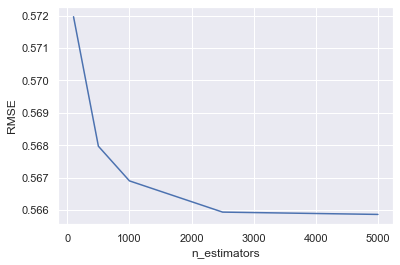

In [54]:
ax = plt.gca()
ax.plot(n_estimators, np.sqrt(error))
#ax.set_xscale('log')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.show()

Nous resserrons nos recherches entre 1000 et 5000 pour trouver la valeur optimale du **n_estimator**.

In [55]:
n_estimators = np.arange(1000,5000,500)
regressor = RandomForestRegressor(random_state=0, max_depth=20)

score = []
error= []

for i in n_estimators :
    regressor.set_params(n_estimators=i)
    regressor.fit(X_train, y_train)
    score.append(regressor.score(X_test, y_test))
    error.append(np.mean((regressor.predict(X_test) - y_test) ** 2))

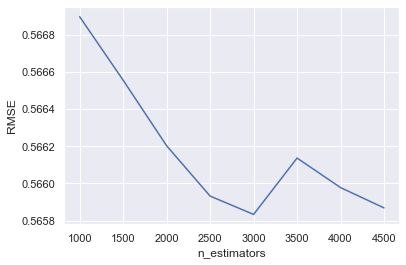

In [56]:
ax = plt.gca()
ax.plot(n_estimators, np.sqrt(error))
#ax.set_xscale('log')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.show()

In [57]:
regressor = RandomForestRegressor(random_state=0, max_depth=20, n_estimators=2000)
regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=2000, random_state=0)

In [58]:
y_predict = regressor.predict(X_test)

In [59]:
print('RMSE: %.3f'
      % np.sqrt(mean_squared_error(y_test, y_predict)))

print('R2: %.3f'
      % r2_score(y_test, y_predict))

RMSE: 0.566
R2: 0.747


In [60]:
evaluation.iloc[1][3]=r2_score(y_test, y_predict).round(3)
evaluation.iloc[1][4]=np.sqrt(mean_squared_error(y_test, y_predict)).round(3)
evaluation.iloc[1][6]= 20
evaluation.iloc[1][7]= 2000
evaluation

,Modele,R2_Initial,RMSE_Initial,R2_Final,RMSE_Final,alpha,max_depth,n_estimators
0,Regression Ridge,0.553,0.752,0.528,0.773,500,NaN,NaN
1,Random Forest Regressor,0.714,0.602,0.747,0.566,NaN,20,2000
2,XGBoost Regressor,NaN,NaN,NaN,NaN,NaN,NaN,NaN


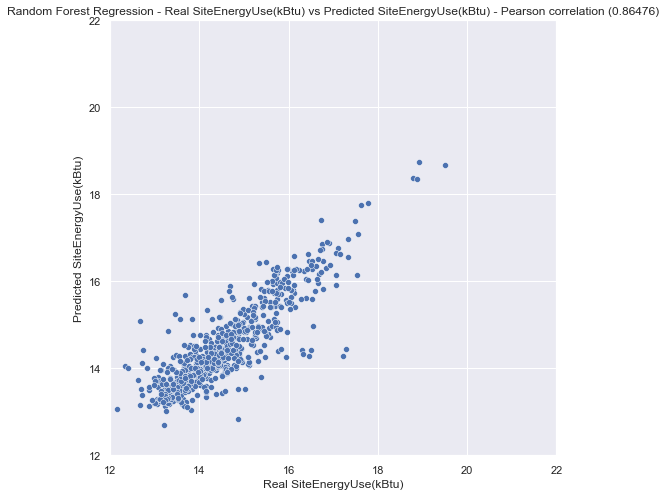

In [61]:
correlation = round(pearsonr(y_predict, y_test)[0], 5)
 
output_filename = "rf_regression.png"
title_name = "Random Forest Regression - Real SiteEnergyUse(kBtu) vs Predicted SiteEnergyUse(kBtu) - Pearson correlation ({})".format(correlation)
x_axis_label = "Real SiteEnergyUse(kBtu)"
y_axis_label = "Predicted SiteEnergyUse(kBtu)"
 
plt.figure(figsize=(8, 8))
plt.title(title_name)

ax = sns.scatterplot(x=y_test, y=y_predict)

ax.set(xlabel=x_axis_label, ylabel=y_axis_label)
plt.xlim(12,22)
plt.ylim(12,22)
plt.savefig(output_filename, bbox_inches='tight', dpi=300)
plt.show()
plt.close()

## XGBoost Regressor

In [62]:
xgbr = xgb.XGBRegressor()

In [63]:
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [64]:
y_pred = xgbr.predict(X_test)

In [65]:
print('RMSE: %.3f'
      % np.sqrt(mean_squared_error(y_test, y_pred)))

print('R2: %.3f'
      % r2_score(y_test, y_pred))

RMSE: 0.585
R2: 0.729


In [66]:
evaluation.iloc[2][1]=r2_score(y_test, y_pred).round(3)
evaluation.iloc[2][2]=np.sqrt(mean_squared_error(y_test, y_pred)).round(3)
evaluation

,Modele,R2_Initial,RMSE_Initial,R2_Final,RMSE_Final,alpha,max_depth,n_estimators
0,Regression Ridge,0.553,0.752,0.528,0.773,500,NaN,NaN
1,Random Forest Regressor,0.714,0.602,0.747,0.566,NaN,20,2000
2,XGBoost Regressor,0.729,0.585,NaN,NaN,NaN,NaN,NaN


### Feature importances

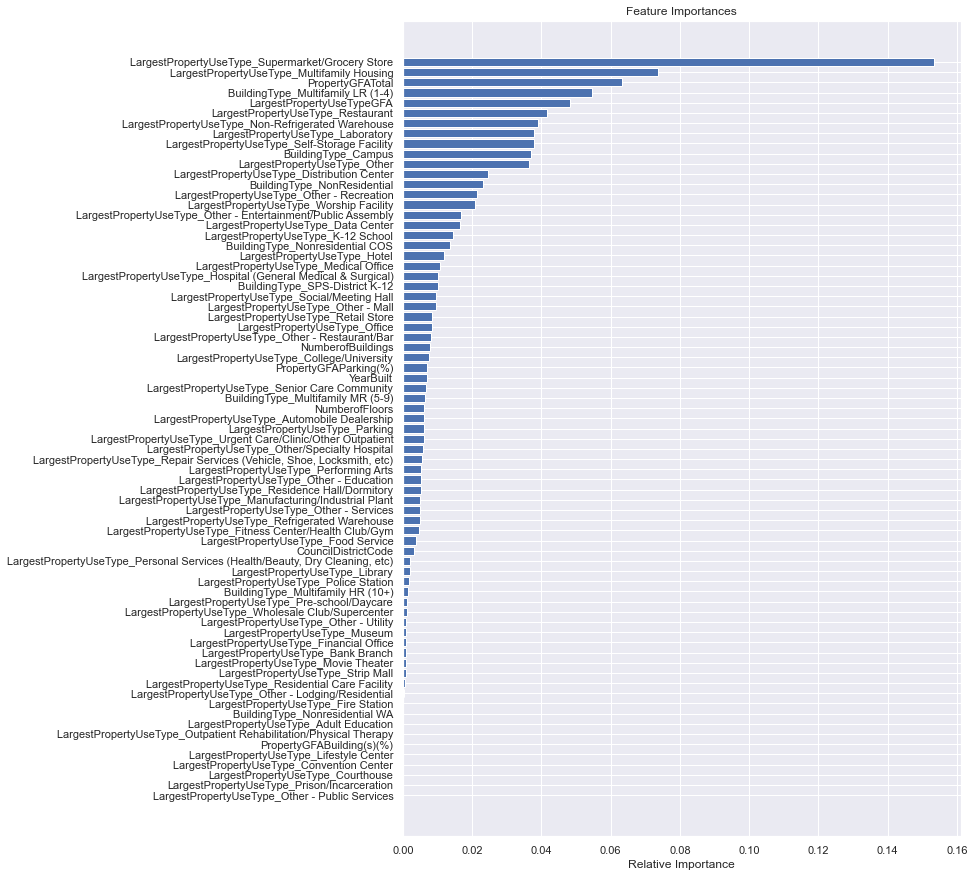

In [67]:
importances = xgbr.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 15))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Recherche des hyperparamètres
#### GridSearchCV

In [68]:
XGBR = xgb.XGBRegressor()

params = {'max_depth':np.arange(1,56,5)}

grid1 = GridSearchCV(estimator=XGBR, param_grid=params, scoring = 'neg_mean_squared_error', refit = True, cv=10)

grid1.fit(X, Y)

print("Meilleurs paramètres: %s" % grid1.best_params_)
print("RMSE des meilleurs paramètres: %.3f" % np.sqrt(abs(grid1.best_score_)))

Meilleurs paramètres: {'max_depth': 1}
RMSE des meilleurs paramètres: 0.597


In [69]:
best_XGBR = xgb.XGBRegressor(max_depth=grid1.best_params_['max_depth'])
best_XGBR.fit(X_train, y_train)
y_pred = best_XGBR.predict(X_test)
print("Meilleur R²: %.5f" % r2_score(y_test,y_pred))

Meilleur R²: 0.74599


#### Visualisation

In [70]:
max_depth = np.arange(1,51,2)
XGBR = xgb.XGBRegressor()

score = []
error= []

for i in max_depth :
    XGBR.set_params(max_depth=i)
    XGBR.fit(X_train, y_train)
    score.append(XGBR.score(X_test, y_test))
    error.append(np.mean((XGBR.predict(X_test) - y_test) ** 2))

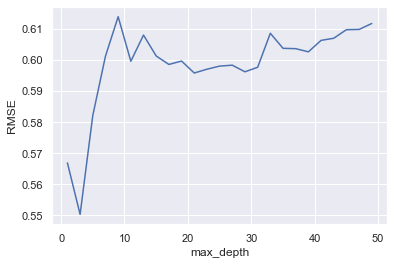

In [71]:
ax = plt.gca()
ax.plot(max_depth, np.sqrt(error))
#ax.set_xscale('log')
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.show()

In [72]:
max_depth = np.arange(0,5,1)
XGBR = xgb.XGBRegressor()

score = []
error= []

for i in max_depth :
    XGBR.set_params(max_depth=i)
    XGBR.fit(X_train, y_train)
    score.append(XGBR.score(X_test, y_test))
    error.append(np.mean((XGBR.predict(X_test) - y_test) ** 2))

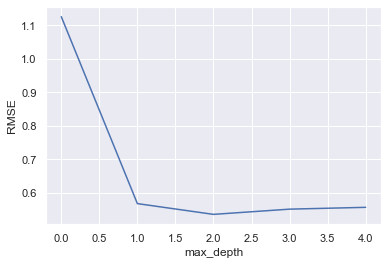

In [73]:
ax = plt.gca()
ax.plot(max_depth, np.sqrt(error))
#ax.set_xscale('log')
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.show()

Nous gardons **max_depth  2** et testons desormais avec **n_estimator**.

In [74]:
#n_estimators = np.arange(100,2100,100)
n_estimators = [10, 100, 250, 500, 1000, 2000, 5000]
XGBR = xgb.XGBRegressor(max_depth = 2)

score = []
error= []

for i in n_estimators :
    XGBR.set_params(n_estimators=i)
    XGBR.fit(X_train, y_train)
    score.append(XGBR.score(X_test, y_test))
    error.append(np.mean((XGBR.predict(X_test) - y_test) ** 2))

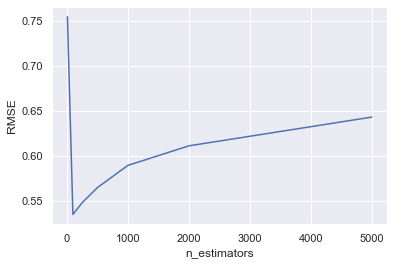

In [75]:
ax = plt.gca()
ax.plot(n_estimators, np.sqrt(error))
#ax.set_xscale('log')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.show()

In [76]:
n_estimators = np.arange(50,200,2)
XGBR = xgb.XGBRegressor(max_depth = 2)

score = []
error= []

for i in n_estimators :
    XGBR.set_params(n_estimators=i)
    XGBR.fit(X_train, y_train)
    score.append(XGBR.score(X_test, y_test))
    error.append(np.mean((XGBR.predict(X_test) - y_test) ** 2))

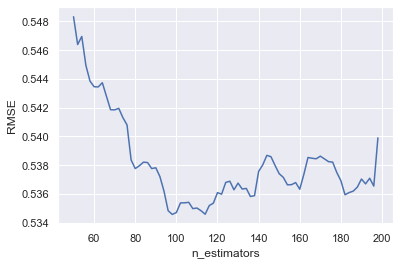

In [77]:
ax = plt.gca()
ax.plot(n_estimators, np.sqrt(error))
#ax.set_xscale('log')
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.show()

In [89]:
XGBR = xgb.XGBRegressor(max_depth = 2, n_estimators = 100)
XGBR.fit(X_train, y_train)
y_pred = XGBR.predict(X_test)

In [90]:
print('RMSE: %.3f'
      % np.sqrt(mean_squared_error(y_test, y_pred)))

print('R2: %.3f'
      % r2_score(y_test, y_pred))

RMSE: 0.535
R2: 0.774


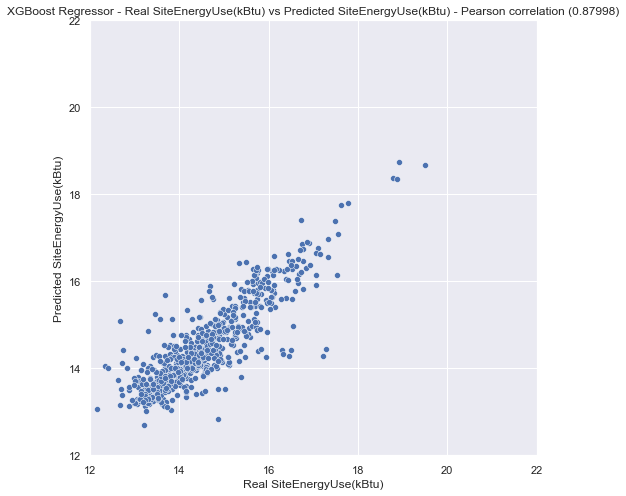

In [92]:
correlation = round(pearsonr(y_pred, y_test)[0], 5)
 
output_filename = "xgbregressor.png"
title_name = "XGBoost Regressor - Real SiteEnergyUse(kBtu) vs Predicted SiteEnergyUse(kBtu) - Pearson correlation ({})".format(correlation)
x_axis_label = "Real SiteEnergyUse(kBtu)"
y_axis_label = "Predicted SiteEnergyUse(kBtu)"


plt.figure(figsize=(8, 8))
plt.title(title_name)

ax = sns.scatterplot(x=y_test, y=y_predict)

ax.set(xlabel=x_axis_label, ylabel=y_axis_label)
plt.xlim(12,22)
plt.ylim(12,22)
plt.savefig(output_filename, bbox_inches='tight', dpi=300)
plt.show()
plt.close()

In [91]:
evaluation.iloc[2][3]=r2_score(y_test, y_pred).round(3)
evaluation.iloc[2][4]=np.sqrt(mean_squared_error(y_test, y_pred)).round(3)
evaluation.iloc[2][6]=2
evaluation.iloc[2][7]=100
evaluation

,Modele,R2_Initial,RMSE_Initial,R2_Final,RMSE_Final,alpha,max_depth,n_estimators
0,Regression Ridge,0.553,0.752,0.528,0.773,500,NaN,NaN
1,Random Forest Regressor,0.714,0.602,0.747,0.566,NaN,20,2000
2,XGBoost Regressor,0.729,0.585,0.774,0.535,NaN,2,100


Sur notre tableau d'évaluation nos concluons que le 3 ème modèle **XGBOOST** est les plus performant devançant le Random Forest Regressor. Ce sera donc le modèle final choisi pour la mise en production de notre algorithme de prédiction de dépense énergétique.

## EnergyscoreStar

Afin d'étudier la performance de cette méthode de scoring nous allons ajouter l'ENERGYSTARScore à notre algorithme afin de voir comment cela améliore ou non les performances. 

In [21]:
drop_columns_2 = ['OSEBuildingID','TaxParcelIdentificationNumber','ComplianceStatus','PropertyGFAParking','PropertyGFABuilding(s)','Neighborhood',
                'ListOfAllPropertyUseTypes', 'PrimaryPropertyType', 'SiteEUI(kBtu/sf)','SourceEUI(kBtu/sf)', 'ZipCode',
               'Electricity(kBtu)', 'NaturalGas(kBtu)', 'SteamUse(kBtu)', 'Latitude', 'Longitude', 'GHGEmissionsIntensity','TotalGHGEmissions','DataYear']

In [22]:
data_pred_2 = seattle_pred.drop(drop_columns_2, axis=1).dropna()
data_pred_2.head()

,BuildingType,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),PropertyGFAParking(%),PropertyGFABuilding(s)(%)
0,NonResidential,7,1927,1.0,12.0,88434,Hotel,88434.0,60.0,7226362.5,0.000000,100.000000
1,NonResidential,7,1996,1.0,11.0,103566,Hotel,83880.0,61.0,8387933.0,14.545314,85.454686
2,NonResidential,7,1969,1.0,41.0,956110,Hotel,756493.0,43.0,72587024.0,20.574829,79.425171
3,NonResidential,7,1926,1.0,10.0,61320,Hotel,61320.0,56.0,6794584.0,0.000000,100.000000
4,NonResidential,7,1980,1.0,18.0,175580,Hotel,123445.0,75.0,14172606.0,35.311539,64.688461


In [23]:
df_numeric_2 = pd.get_dummies(data_pred_2)
df_ml_2 = df_numeric_2.loc[(df_numeric_2[target] != 0)]

feature_names_2 = df_ml_2.drop(target,axis=1).columns

In [24]:
x2 = df_ml_2.drop(target,axis=1).values
y2 = df_ml_2[target].values

In [25]:
Y2 = np.log(y2)
std2 = StandardScaler()
X2 = std2.fit_transform(x2)

In [26]:
from sklearn.model_selection import train_test_split

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, Y2, test_size=0.20)

In [27]:
XGBR = xgb.XGBRegressor(max_depth = 2, n_estimators = 100)
XGBR.fit(X_train2, y_train2)
y_pred2 = XGBR.predict(X_test2)

In [28]:
print('RMSE: %.3f'
      % np.sqrt(mean_squared_error(y_test2, y_pred2)))

print('R2: %.3f'
      % r2_score(y_test2, y_pred2))

RMSE: 0.363
R2: 0.887


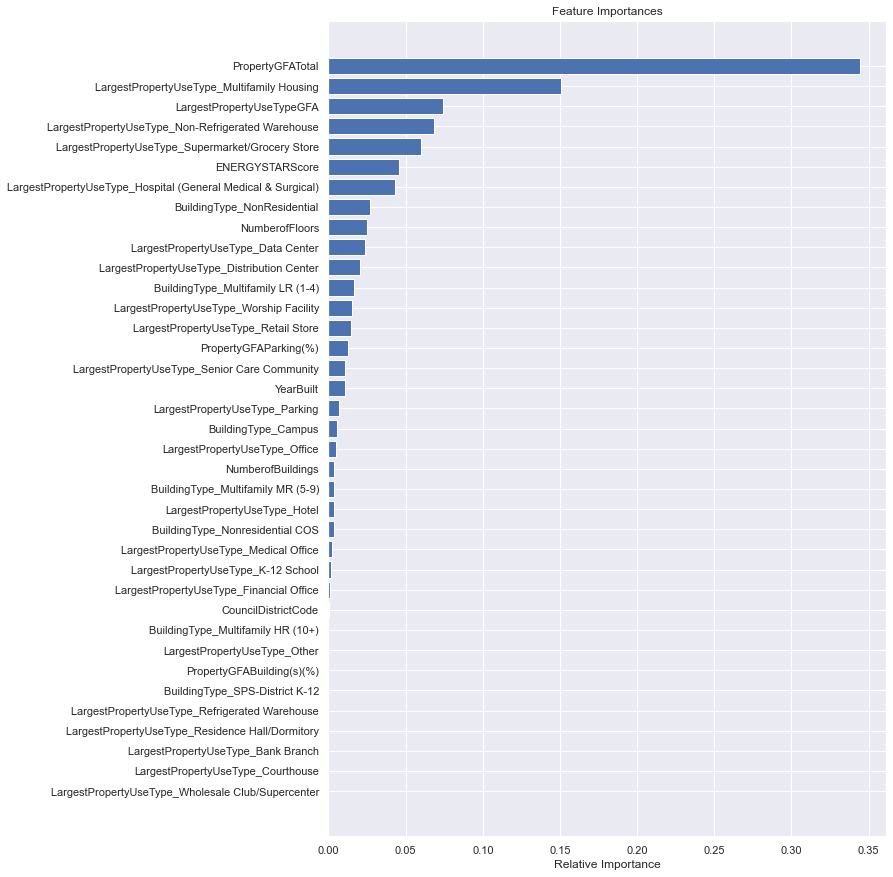

In [34]:
importances = XGBR.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 15))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names_2[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Nous remarquons qu'en ajoutant l'ENERGYSTARScore dans notre algo nous avons des performances extrêmement bonnes, augmentant de plus de 0.1 notre R². Cette feature se classe en 6 ème position sur avec notre XGBOOST. 

Le fait que celui-ci améliore nos performances nous permet d'en déduire qu'il a un impact positif et qu'il a du sens, bien que cela de provaoque pas une fuite de données. Celui-ci n'es donc pas complètement fidèle à la consommation d'énergie des bâtiments, nous pourons le discréditer après avoir mis en production notre algorithme XGBOOST.

